# Importing packages

In [1]:
import gc
import os
import time
import pywt
import logging
import datetime
import warnings
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import pandas as pd
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import seaborn as sns
import xgboost as xgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

# Processing train data, visualizing data

In [2]:
%%time
train_df = pd.read_csv("LANL-Earthquake-Prediction/train.csv",
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1min 10s, sys: 10.5 s, total: 1min 20s
Wall time: 1min 13s


In [3]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


Let us visualize all train data

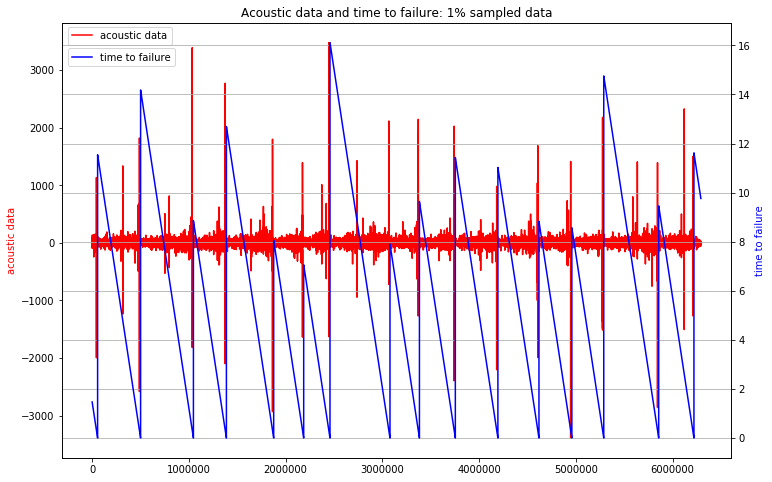

In [4]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
plt.savefig("train_data_plotted.pdf")
del train_ad_sample_df
del train_ttf_sample_df

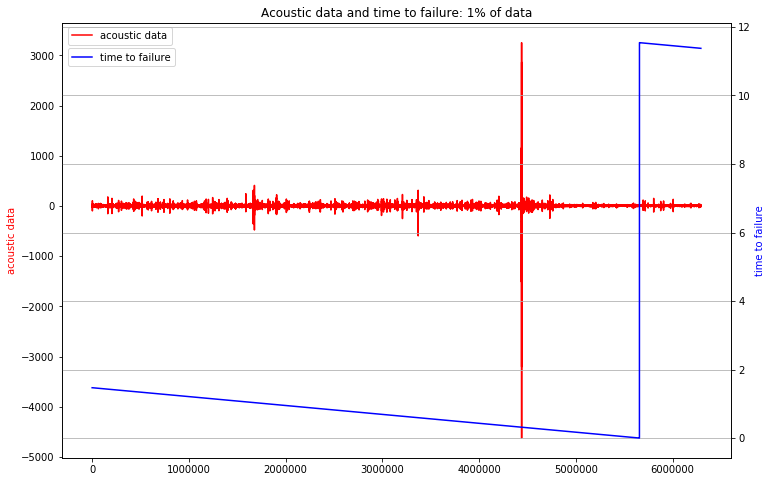

In [5]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

In the next several cells we process the data for XGBoost. Window frame has size 150000

In [4]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [5]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [6]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

We replace outliers in the original signal by extreme values (mean $\pm$ 3 std )

In [7]:
def replace_outliers(X, mean, std):
    X.loc[X > mean + 3 * std] = mean + 3 * std
    X.loc[X < mean - 3 * std] = mean - 3 * std

In [8]:
replace_outliers(train_df['acoustic_data'], total_mean, total_std)

Below is the main function for generating features

In [9]:
def create_features(seg_id, seg, X):
    n_freq = 4
    w_window = 5000 # averaging window for transformed data
    n_rows = seg.shape[0] 
    n_w_windows = int(n_rows / w_window)
    
    xc = pd.Series(seg['acoustic_data'].values)
    [yc_morl, _] = pywt.cwt(xc, np.arange(1, n_freq), 'cmor')
    [yc_mexh, _] = pywt.cwt(xc, np.arange(1, n_freq), 'mexh')
    
    zc = np.fft.fft(xc)
    
    #Standard features
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    X.loc[seg_id, 'ave_min_max'] = (xc.min() + xc.max()) / 2
    
    
    #Morlet wavelet transform features
    for scale in range(n_freq - 1):
        for idx in range(n_w_windows):
            curr_real = np.real(yc_morl[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rmean'] = np.nanmean(curr_real)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rstd'] = np.nanstd(curr_real)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rmax'] = curr_real.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rmin'] = curr_real.min()
            curr_imag = np.imag(yc_morl[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Imean'] = np.nanmean(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Istd'] = np.nanstd(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Imax'] = curr_imag.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Imin'] = curr_imag.min()
            
            curr_real = np.real(yc_mexh[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rmean'] = np.nanmean(curr_real)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rstd'] = curr_real.std()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rmax'] = curr_real.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rmin'] = curr_real.min()
            curr_imag = np.imag(yc_mexh[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Imean'] = np.nanmean(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Istd'] = np.nanstd(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Imax'] = curr_imag.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Imin'] = curr_imag.min()

            

    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000, 10000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [10]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [11]:
train_X.shape

(4194, 1617)

In [386]:
train_X = pd.read_csv("features_150k_f")
train_y = pd.read_csv("labels_150k_f")

In [ ]:
train_X.shape

Processing train data requires a decent amount of time. We save it to the file in order to load it in further sessions.

In [15]:
train_X.to_csv("features_150k_f", index=False)
train_y.to_csv("labels_150k_f", index=False)

In [388]:
train_X.fillna(0);

In [389]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [390]:
scaled_train_X.head(10)

,mean,std,max,min,ave_min_max,0_0morlRmean,0_0morlRstd,0_0morlRmax,0_0morlRmin,0_0morlImean,...,std_roll_mean_10000,max_roll_mean_10000,min_roll_mean_10000,q01_roll_mean_10000,q05_roll_mean_10000,q95_roll_mean_10000,q99_roll_mean_10000,av_change_abs_roll_mean_10000,av_change_rate_roll_mean_10000,abs_max_roll_mean_10000
0,1.424140,-0.170214,-0.218194,0.193218,-0.107471,0.367346,2.825327,2.296255,-2.079622,0.515557,...,1.925160,1.006144,0.406500,0.431175,0.472356,1.485590,1.366119,-1.773682,-1.621941,1.006144
1,0.805716,0.004734,0.063936,-0.018037,0.163411,-0.431755,-0.208800,-0.169324,0.152503,0.145499,...,-0.992027,0.167985,0.837666,0.983560,1.036698,0.427425,0.302543,0.475910,-1.239019,0.167985
2,1.511155,0.049252,-0.086289,0.163039,0.253705,0.097283,1.537630,2.036399,-2.113358,0.393995,...,0.861607,1.116291,0.684092,0.794789,0.988987,1.565416,1.490006,1.742965,0.435491,1.116291
3,1.494934,0.043950,0.122560,-0.187796,-0.210665,-0.585586,-0.221609,-0.257106,0.304480,-0.809752,...,0.324826,0.927232,0.930680,1.121748,1.150014,1.375689,1.249729,0.472065,-0.498848,0.927232
4,1.520242,0.088495,-0.067969,0.087590,0.060218,-0.346660,0.415069,0.551631,-0.646122,1.329881,...,-0.634956,1.059299,1.254344,1.508821,1.542147,1.268759,1.327203,-0.814565,0.137390,1.059299
5,1.538962,-0.131054,-0.078961,0.019687,-0.210665,-0.213615,-0.388418,-0.410223,0.428013,0.979269,...,1.429438,1.348915,0.934447,1.142641,1.357263,1.863930,1.815970,-0.728580,0.525981,1.348915
6,1.313016,-0.101219,-0.159569,0.268667,0.356898,0.186183,-0.488463,-0.485647,0.346561,-1.046336,...,-0.759117,0.706664,1.102509,1.371732,1.294641,0.985839,0.928764,-0.065516,-0.140607,0.706664
7,-0.054824,-0.081617,-0.089953,0.057411,-0.120371,-0.678832,-0.494903,-0.412764,0.451235,1.367293,...,-0.180357,-0.298633,0.064002,0.037504,0.025802,-0.266879,-0.336888,-0.618477,0.818341,-0.298633
8,0.774732,0.145944,0.016304,-0.025582,-0.030076,0.345663,3.413379,2.881862,-3.609575,0.061129,...,-0.052862,0.353207,0.536024,0.600152,0.673268,0.572598,0.482483,-0.547522,0.044961,0.353207
9,0.825999,0.040205,-0.042321,0.087590,0.150512,-0.568608,-0.103585,-0.175858,0.236011,-0.236177,...,0.088563,0.512400,0.554569,0.682259,0.617728,0.806137,0.746682,2.313402,-0.964376,0.512400


We also create a feature matrix, each row of which aggregates information from 30k signal points. This is preprocessed data for RNN.

In [16]:
rows = 30000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  20971


In [18]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [19]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [22]:
scaler_30k = StandardScaler()
scaler_30k.fit(train_X)
scaled_train_X = pd.DataFrame(scaler_30k.transform(train_X), columns=train_X.columns)

In [20]:
train_X.to_csv("features_30k_f", index=False)
train_y.to_csv("labels_30k_f", index=False)

In [21]:
train_X.shape

(20971, 465)

In [2]:
train_X = pd.read_csv("features_30k_f")
train_y = pd.read_csv("labels_30k_f")

# Processing test data [for submission to Kaggle]

In [ ]:
submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [ ]:
submission.shape, test_X.shape

In [ ]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [ ]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [261]:
rows = 30000

In [262]:
submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64)

In [263]:
for seg_id in tqdm_notebook(submission.index):
    seg = pd.read_csv('LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    for i in range(5):
        seg_i = seg[rows * i : rows * (i + 1)]
        create_features(seg_id + '_' + str(i), seg_i, test_X)

In [381]:
test_X.shape

(13120, 465)

In [ ]:
scaled_test_X = pd.DataFrame(scaler_30k.transform(test_X), columns=test_X.columns)

# Tuning XGBoost parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xgtrain = xgb.DMatrix(train_X.values, label=train_y.values)

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.1,
    'min_child_weight' : 1,
    'subsample' : 0.8,
    'max_depth' : 5,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_1 = {
 'max_depth' : range(3, 10, 2),
 'min_child_weight' : range(1, 6, 2)
}

gsearch_1 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_1, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_1.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_1.cv_results_)

In [ ]:
gsearch_1.best_params_, gsearch_1.best_score_

In [ ]:
param_test_2 = {
 'max_depth' : range(8, 12),
 'min_child_weight' : range(1, 4)
}

gsearch_2 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_2, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_2.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_2.cv_results_)

In [ ]:
gsearch_2.best_params_, gsearch_2.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.1,
    'min_child_weight' : 1,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_3 = {
 'min_child_weight' : range(1, 6)
}

gsearch_3 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_3, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_3.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_3.cv_results_)

In [ ]:
gsearch_3.best_params_, gsearch_3.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.1,
    'min_child_weight' : 2,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_4 = {
 'gamma' : np.linspace(0, 0.5, 10)
}

gsearch_4 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_4, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_4.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_4.cv_results_)

In [ ]:
gsearch_4.best_params_, gsearch_4.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_5 = {
 'subsample' : [i/10.0 for i in range(6,10)],
 'colsample_bytree' : [i/20.0 for i in range(1,20)]
}

gsearch_5 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_5, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_5.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_5.cv_results_)

In [ ]:
gsearch_5.best_params_, gsearch_5.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch_6 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_6, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_6.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_6.cv_results_)

In [ ]:
gsearch_6.best_params_, gsearch_6.best_score_

In [ ]:
param_test_7 = {
    'reg_alpha': np.arange(100, 12000, 100)
}

gsearch_7 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_7, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_7.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_7.cv_results_)

In [ ]:
gsearch_7.best_params_, gsearch_7.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27,
    'reg_alpha' : 400 
}

Adjusting parameters manually

In [387]:
params = {
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.05,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_jobs' : 20,
    'seed' : 27,
    'reg_alpha' : 0.75,
    'n_estimators' : 85
}

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [ ]:
maer = 0
reg_alphas = np.linspace(0, 1, 9)
counter = 0
for reg_alpha in reg_alphas:
    aggr_val = 0
    aggr_tr = 0
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
        strLog = "fold {}".format(fold_)
        # print(strLog)

        X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = xgb.XGBRegressor(**params, reg_alpha=reg_alpha)
        model.fit(X_tr, 
                  y_tr,
                  eval_metric='rmse',
                 )
        aggr_tr += mean_absolute_error(model.predict(X_tr), y_tr)
        aggr_val += mean_absolute_error(model.predict(X_val), y_val)
        # print('tr_loss', maer_tr, ': val_loss', maer)
    print(counter, ': prm_value =', reg_alpha, ': tr_loss :', aggr_tr / n_fold, ', val_loss :', aggr_val / n_fold)
    counter += 1

Training final model

In [392]:
val_frac = 0.2

In [393]:
t_ind_xgb = int(len(scaled_train_X) * (1 - val_frac))

In [398]:
xgb_final = xgb.XGBRegressor(**params)
xgb_final.fit(scaled_train_X[:t_ind_xgb], train_y[:t_ind_xgb])
y_val_xgb = xgb_final.predict(scaled_train_X[t_ind_xgb:])
mean_absolute_error(y_val_xgb, train_y[t_ind_xgb:])

2.5349424301005046

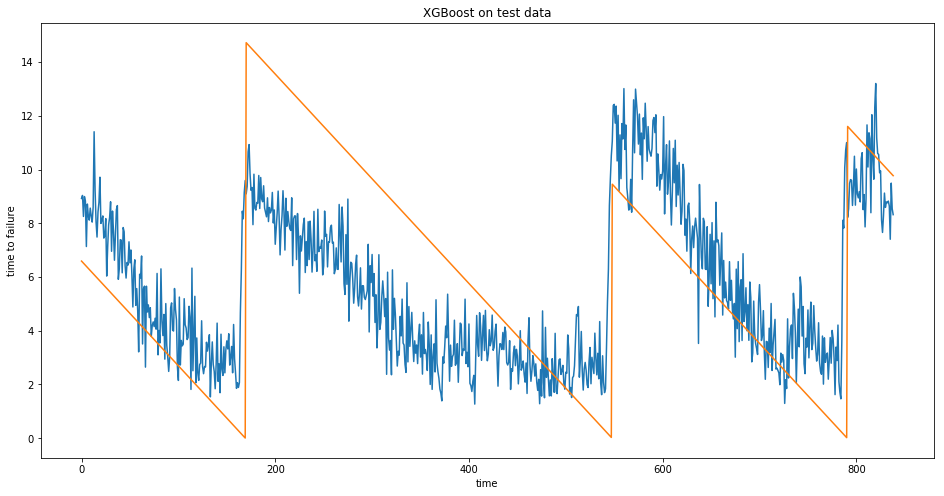

In [430]:
plt.figure(figsize=(16, 8))
plt.xlabel("time")
plt.ylabel("time to failure")
plt.title("XGBoost on test data")
plt.plot(range(len(y_val_xgb)), y_val_xgb)
plt.plot(range(len(y_val_xgb)), train_y[t_ind_xgb:])
plt.savefig("xgboost.png")

In [ ]:
# predictions_xgb = xgb_final.predict(scaled_test_X)
# submission['time_to_failure'] = predictions_xgb
# submission.to_csv('xgg_only_prediction_subm')
# submission.head()

# Recurrent neural network

In [23]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available')

Training on GPU!


In [24]:
class EarthquakeRNN(nn.Module):
    
    def __init__(self, n_input, n_output, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # the LSTM
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # batch normalization layer
        self.bn1 = nn.BatchNorm1d(num_features=n_hidden)
        
        # the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, n_output)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        # getting the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        # passing through a dropout layer
        out = self.dropout(r_output)
        
        # stacking up LSTM outputs using view
        out = out.contiguous().view(-1, self.n_hidden)

        # passing through normalization layer
        out = self.bn1(out)
        
        # putting x through the fully-connected layer
        out = self.fc(out)
        
        # the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

In [66]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):

    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    # val_data, data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.float().cuda(), targets.float().cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length, -1).float())
            
            # adding l1 and l2 regularizers to the loss
            l2 = 0
            l1 = 0
            for p in net.parameters():
                l2 += l2 + 5e-5 * (p**2).sum()
                l1 += l1 + 5e-5 * p.abs().sum()
            loss += l2 + l1
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
                    if(train_on_gpu):
                        inputs, targets = inputs.float().cuda(), targets.float().cuda()
                    val_h = tuple([each.data for each in val_h])    
                    output, val_h = net(inputs, val_h)
            
                    val_loss = criterion(output, targets.view(batch_size*seq_length, -1).float())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item() - l2.item() - l1.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [26]:
def get_batches(data, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array we want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of time stamps in a sequence
    '''
    features = data[:, 0:-1]
    n_input_f = features.shape[1]
    labels = data[:, -1]
    try:
        n_input_l = labels.shape[1]
    except IndexError:
        n_input_l = 1
    batch_size_total = batch_size * seq_length
    
    # total number of batches we can make
    n_batches = features.shape[0]//batch_size_total
    
    # Keep only enough time points to make full batches
    features = features[:n_batches * batch_size_total]
    labels = labels[:n_batches * batch_size_total]

    # Reshape into batch_size rows
    features = features.reshape((batch_size, -1, n_input_f))
    labels = labels.reshape((batch_size, -1, n_input_l))

    # iterate through the array, one sequence at a time
    for n in range(0, features.shape[1], seq_length):
        x = features[:, n : n+seq_length, :]
        y = labels[:, n : n+seq_length, :]
        yield x, y

In [28]:
scaled_train_X.shape

(20971, 465)

In [29]:
data = np.hstack([scaled_train_X, train_y])

In [68]:
# define and print the net |||||||||
n_hidden= 64
n_layers=2
n_input = 465
n_output=1

net2 = EarthquakeRNN(n_input, n_output, n_hidden, n_layers, drop_prob=0.7)
print(net2)

EarthquakeRNN(
  (lstm): LSTM(465, 64, batch_first=True, dropout=0.7)
  (dropout): Dropout(p=0.7)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [332]:
batch_size = 100
seq_length = 40
n_epochs = 400 # start smaller if you are just testing initial behavior

# train the model
train(net2, data, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.005, print_every=100, val_frac=0.2)

Epoch: 25/400... Step: 100... Loss: 5.8423... Val Loss: 9.8865
Epoch: 50/400... Step: 200... Loss: 5.9252... Val Loss: 9.6928
Epoch: 75/400... Step: 300... Loss: 5.2564... Val Loss: 9.9457
Epoch: 100/400... Step: 400... Loss: 5.5125... Val Loss: 9.5799
Epoch: 125/400... Step: 500... Loss: 5.9127... Val Loss: 9.4971
Epoch: 150/400... Step: 600... Loss: 5.6543... Val Loss: 8.8495
Epoch: 175/400... Step: 700... Loss: 5.5561... Val Loss: 10.2677
Epoch: 200/400... Step: 800... Loss: 5.2696... Val Loss: 11.1430
Epoch: 225/400... Step: 900... Loss: 5.1693... Val Loss: 9.5838
Epoch: 250/400... Step: 1000... Loss: 5.7884... Val Loss: 10.6691
Epoch: 275/400... Step: 1100... Loss: 4.8060... Val Loss: 12.2221
Epoch: 300/400... Step: 1200... Loss: 5.4398... Val Loss: 9.6430
Epoch: 325/400... Step: 1300... Loss: 5.3100... Val Loss: 8.9928
Epoch: 350/400... Step: 1400... Loss: 5.1562... Val Loss: 9.8671
Epoch: 375/400... Step: 1500... Loss: 5.1035... Val Loss: 9.5067
Epoch: 400/400... Step: 1600... L

Testing RNN on whole validation set

In [344]:
hh = net2.init_hidden(1)

torch.Size([2, 1, 64])

In [367]:
val_frac = 0.2
n_obj = scaled_train_X.shape[0]
t_ind = int((1 - val_frac) * n_obj)
y_val = train_y[t_ind:]
x_val = scaled_train_X[t_ind:]

In [368]:
x_val = np.expand_dims(x_val.values, axis=0) # making shape consistent for RNN

In [369]:
x, hh = net2(torch.from_numpy(x_val).float().cuda(), hh)

In [370]:
x =  x.cpu().detach().numpy()

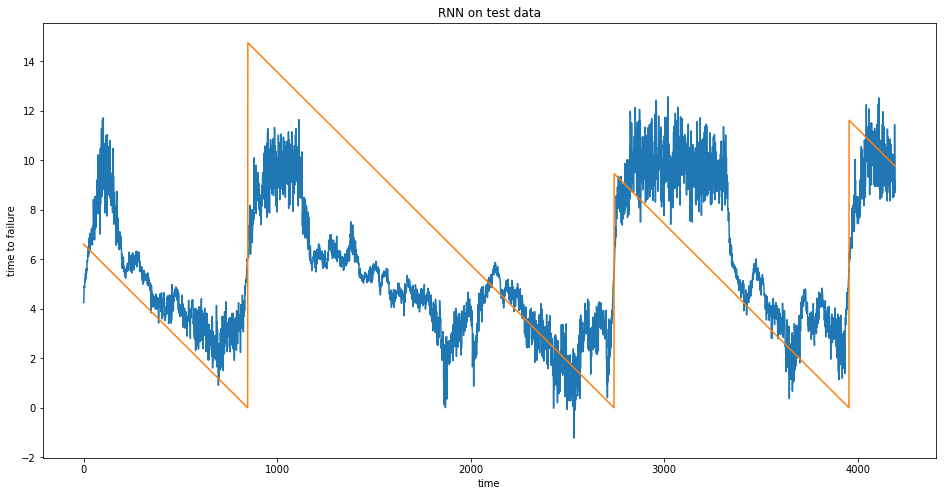

In [432]:
plt.figure(figsize=(16, 8))
plt.xlabel("time")
plt.ylabel("time to failure")
plt.title("RNN on test data")
plt.plot(range(x.shape[0]), x)
plt.plot(range(x.shape[0]), y_val)
plt.savefig("RNN_on_test_data.png")

In [375]:
mean_absolute_error(x, y_val)

2.429692163897836

# Combining models outputs

In [417]:
x.squeeze().shape

(4195,)

In [402]:
y_val_xgb.shape

(839,)

In [419]:
y_comb = (x.squeeze()[::5] + y_val_xgb) / 2
mean_absolute_error(y_comb, train_y[t_ind_xgb:])

2.382668560543414

# Baseline approach

In [378]:
y_base = y_val.median()['time_to_failure']
baseline_error = mean_absolute_error(np.ones_like(y_val) * y_base, y_val)

In [379]:
print('Baseline method gives mean absolute error', baseline_error)

Baseline method gives mean absolute error 3.2514733233965303
